## 导入工具包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

## 载入模型

In [2]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('new_cfg2.py')

In [3]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

05/14 04:45:18 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Jun  4 2021, 14:48:32) [GCC 7.5.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;ar

/home/featurize/work/MMSegmentation_Tutorials-main/20230215/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/featurize/work/MMSegmentation_Tutorials-main/20230215/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:251: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


05/14 04:45:29 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/14 04:45:29 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

In [5]:
# 初始化模型
checkpoint_path = './work_dirs/tutorial/CE+Dice16000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/tutorial/CE+Dice16000.pth


## 载入测试集图像，或新图像

In [6]:
img = mmcv.imread('Glomeruli-dataset/images/VUHSK_1702_39.png')

## 语义分割预测

In [7]:
result = inference_model(model, img)

In [8]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [9]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [10]:
pred_mask.shape

(1024, 1024)

In [11]:
np.unique(pred_mask)

array([0, 1])

## 可视化语义分割预测结果

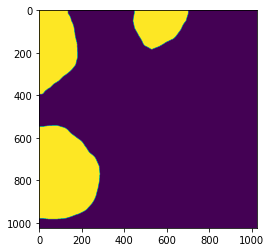

In [12]:
plt.imshow(pred_mask)
plt.show()

/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


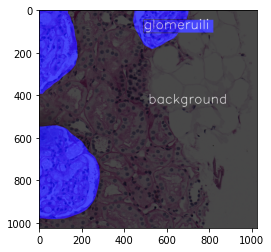

In [13]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

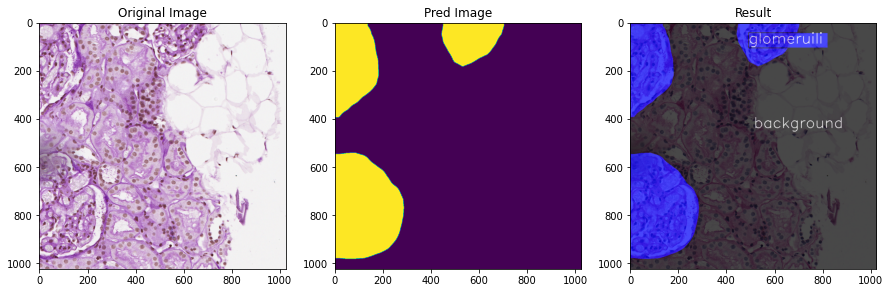

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.title('Pred Image')
plt.imshow(pred_mask)
plt.subplot(1, 3, 3)
plt.title('Result')
plt.imshow(mmcv.bgr2rgb(visualization))

## 语义分割预测结果-连通域分析

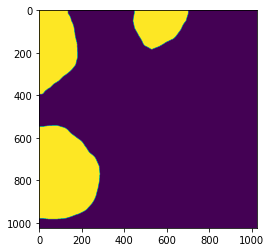

In [15]:
plt.imshow(np.uint8(pred_mask))
plt.show()

In [16]:
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

In [17]:
# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

4

In [18]:
# 用整数表示每个连通域区域
connected[1].shape

(1024, 1024)

In [19]:
np.unique(connected[1])

array([0, 1, 2, 3], dtype=int32)

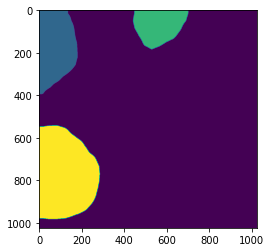

In [20]:
plt.imshow(connected[1])
plt.show()

In [21]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

array([[     0,      0,   1024,   1024, 855269],
       [     0,      0,    181,    395,  56287],
       [   442,      0,    259,    184,  34496],
       [     0,    542,    286,    440, 102524]], dtype=int32)

In [22]:
# 每个连通域的质心坐标
connected[3]

array([[584.65788074, 520.21068927],
       [ 77.89159131, 174.56465969],
       [561.46173469,  73.25797194],
       [122.45323046, 771.2703367 ]])

## 获取测试集标注

In [23]:
label = mmcv.imread('Glomeruli-dataset/masks/VUHSK_1702_39.png')

In [24]:
label_mask = label[:,:,0]

In [25]:
label_mask.shape

(1024, 1024)

In [26]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

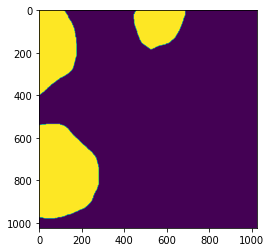

In [27]:
plt.imshow(label_mask)
plt.show()

## 对比测试集标注和语义分割预测结果

In [28]:
# 测试集标注
label_mask.shape

(1024, 1024)

In [29]:
# 语义分割预测结果
pred_mask.shape

(1024, 1024)

In [30]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [31]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [32]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [33]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

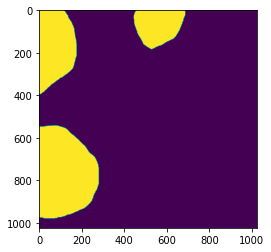

In [34]:
plt.imshow(TP)
plt.show()

In [35]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10

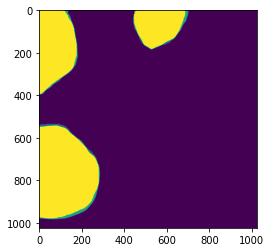

In [36]:
plt.imshow(confusion_map)
plt.show()

## 混淆矩阵

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [39]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [40]:
classes = ('background', 'glomeruili')

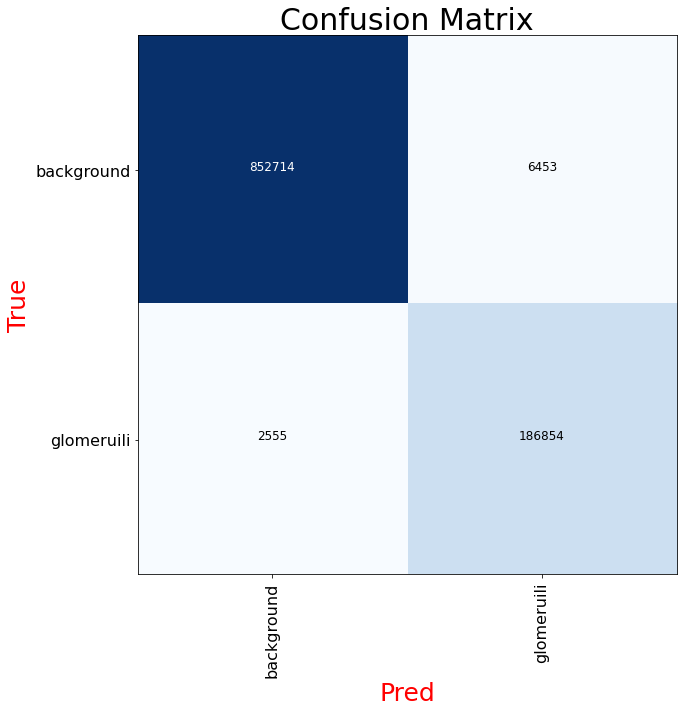

In [41]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')